In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dhs_util
from dhs_util import *
from mlxtend.preprocessing import *
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpmax

os.chdir('C:/Users/christian fink/OneDrive/Math485')
df = pd.read_csv('DisasterDeclarationsSummaries.csv')-



C:\Users\christian fink\AppData\Local\Temp\ipykernel_8120\1586937123.py:16: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



In [155]:
columns_to_drop = ['femaDeclarationString',
                'declarationType', 'declarationDate', 'ihProgramDeclared', 'iaProgramDeclared',
                'paProgramDeclared', 'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate',
                'disasterCloseoutDate', 'tribalRequest', 'fipsStateCode', 'fipsCountyCode', 'declarationRequestNumber',
                'placeCode', 'lastIAFilingDate', 'incidentId', 'region', 'designatedIncidentTypes', 'lastRefresh',
                'hash', 'id'] 
df.drop(columns=columns_to_drop)

,disasterNumber,state,fyDeclared,incidentType,declarationTitle,designatedArea
0,5530,NV,2024,Fire,GOLD RANCH FIRE,Washoe (County)
1,5529,OR,2024,Fire,LEE FALLS FIRE,Washington (County)
2,5528,OR,2024,Fire,ELK LANE FIRE,Jefferson (County)
3,5527,OR,2024,Fire,MILE MARKER 132 FIRE,Deschutes (County)
4,5526,CO,2024,Fire,QUARRY FIRE,Jefferson (County)
...,...,...,...,...,...,...
66849,9,TX,1953,Flood,FLOOD,Statewide
66850,8,IA,1953,Flood,FLOOD,Statewide
66851,7,MA,1953,Tornado,TORNADO,Statewide
66852,2,TX,1953,Tornado,TORNADO & HEAVY RAINFALL,Statewide


In [156]:
grouped_df = df.groupby(['state', 'incidentType']).size().reset_index(name='count')
danger_ratings = {
    'Flood': .000426,
    'Tsunami': .00000774,
    'Snowstorm': .00527,
    'Fire': .018,
    'Tornado': .00608,
    'Hurricane': .0000676,
    'Earthquake': .000017}
grouped_df['dangerRating'] = grouped_df['incidentType'].map(danger_ratings)
grouped_df['totalRating'] = grouped_df['count'] * grouped_df['dangerRating']
pivot_df = grouped_df.pivot_table(index='state', columns='incidentType', values='totalRating', aggfunc='sum', fill_value = 0,)

columns = ['Biological', 'Chemical', 'Coastal Storm', 'Dam/Levee Break', 'Drought', 'Fishing Losses',
            'Straight-Line Winds', 'Freezing', 'Mud/Landslide', 'Other', 'Winter Storm',
           'Severe Ice Storm', 'Severe Storm', 'Terrorist', 'Typhoon', 'Volcanic Eruption',
           'Human Cause', 'Toxic Substances', 'Tropical Storm']
pivot_df = pivot_df.drop(columns = columns)
numeric_columns = pivot_df.columns.difference(['State'])
pivot_df[numeric_columns] = pivot_df[numeric_columns].apply(pd.to_numeric)


pivot_df.rename(columns={'state': 'State', 'incidentType':'IncidentType'}, inplace=True)

valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 
    'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 
    'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 
    'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

pivot_df = pivot_df[pivot_df.index.isin(valid_states)]
state_name_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas',
    'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming'}

pivot_df.index = pivot_df.index.map(state_name_mapping)
pivot_df.sort_index
pivot_df



incidentType,Earthquake,Fire,Flood,Hurricane,Snowstorm,Tornado,Tsunami
state,,,,,,,
Alaska,0.000221,0.558,0.025560,0.000000,0.02108,0.00000,0.000000
Alabama,0.000000,0.198,0.044304,0.045833,0.35309,0.37696,0.000000
Arkansas,0.000000,0.000,0.115446,0.011357,0.08959,0.68704,0.000000
Arizona,0.000000,1.692,0.034932,0.001014,0.00000,0.00000,0.000000
California,0.000544,8.478,0.191274,0.004326,0.00000,0.00000,0.000023
Colorado,0.000000,2.790,0.068160,0.000000,0.28985,0.16416,0.000000
Connecticut,0.000000,0.000,0.007242,0.006490,0.31620,0.03040,0.000000
Delaware,0.000000,0.000,0.001278,0.001487,0.06851,0.00000,0.000000
Florida,0.000000,4.986,0.031524,0.086866,0.00000,0.23104,0.000000


In [157]:
os.chdir("C:/Users/christian fink/OneDrive/Math485/project")
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
    'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
    'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
    'Wyoming']

newdf = pd.DataFrame(columns=['state', 'Homicide', 'Suicide'])

for state in states:
    print(f"Processing data for: {state}")

    try:
        # Load the state's Excel file
        fd = pd.read_csv('C:/Users/christian fink/OneDrive/Math485/project/' + state + '.csv', encoding='ISO-8859-1')

        fd['Deaths'] = pd.to_numeric(fd['Deaths'].str.replace(',', ''), errors='coerce')
        fd['Population'] = pd.to_numeric(fd['Population'].str.replace(',', ''), errors='coerce')
       
        # Filter rows for 'Suicide' and 'Homicide'
        suicide_row = fd[fd['ï»¿"Intent"'] == 'Suicide']
        homicide_row = fd[fd['ï»¿"Intent"'] == 'Homicide']
       
        if not suicide_row.empty and not homicide_row.empty:
            # Extract the death counts and population
            suicide_deaths = suicide_row['Deaths'].values[0]
            homicide_deaths = homicide_row['Deaths'].values[0]
            population = suicide_row['Population'].values[0]  # Assuming population is the same for all rows

            # Calculate the rates
            suicide_rate = (suicide_deaths / population) * 100000  # per 100,000 population
            homicide_rate = (homicide_deaths / population) * 100000  # per 100,000 population
           
            row = pd.DataFrame({
                    'state': [state],        # State name
                    'Homicide': [homicide_rate],  # Homicide rate
                    'Suicide': [suicide_rate]     # Suicide rate
                })
               
                # Append the row to the new DataFrame
            newdf = pd.concat([newdf, row], ignore_index=True)
           
            # Print the results
            print(f"Homicide Rate: {homicide_rate:.2f} per 100,000, Suicide Rate: {suicide_rate:.2f} per 100,000")
        else:
            print(f"Missing data for 'Suicide' or 'Homicide' in {state}.xlsx")
   
    except FileNotFoundError:
        print(f"File for {state} not found.")
    except Exception as e:
        print(f"An error occurred while processing {state}: {e}")



Processing data for: Alabama
Homicide Rate: 13.08 per 100,000, Suicide Rate: 16.38 per 100,000
Processing data for: Alaska
Homicide Rate: 8.55 per 100,000, Suicide Rate: 27.73 per 100,000
Processing data for: Arizona
Homicide Rate: 7.03 per 100,000, Suicide Rate: 20.13 per 100,000
Processing data for: Arkansas
Homicide Rate: 10.48 per 100,000, Suicide Rate: 18.85 per 100,000
Processing data for: California
Homicide Rate: 5.52 per 100,000, Suicide Rate: 10.95 per 100,000
Processing data for: Colorado
Homicide Rate: 5.66 per 100,000, Suicide Rate: 22.75 per 100,000
Processing data for: Connecticut
Homicide Rate: 3.65 per 100,000, Suicide Rate: 11.21 per 100,000
Processing data for: Delaware
Homicide Rate: 7.32 per 100,000, Suicide Rate: 12.40 per 100,000
Processing data for: Florida
Homicide Rate: 6.57 per 100,000, Suicide Rate: 15.65 per 100,000
Processing data for: Georgia
Homicide Rate: 9.64 per 100,000, Suicide Rate: 14.83 per 100,000
Processing data for: Hawaii
Homicide Rate: 2.81 p

C:\Users\christian fink\AppData\Local\Temp\ipykernel_8120\2643976274.py:47: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Homicide Rate: 17.72 per 100,000, Suicide Rate: 14.61 per 100,000
Processing data for: Missouri
Homicide Rate: 11.53 per 100,000, Suicide Rate: 19.15 per 100,000
Processing data for: Montana
Homicide Rate: 4.57 per 100,000, Suicide Rate: 28.14 per 100,000
Processing data for: Nebraska
Homicide Rate: 3.20 per 100,000, Suicide Rate: 14.94 per 100,000
Processing data for: Nevada
Homicide Rate: 7.17 per 100,000, Suicide Rate: 21.15 per 100,000
Processing data for: New Hampshire
Homicide Rate: 1.64 per 100,000, Suicide Rate: 18.00 per 100,000
Processing data for: New Jersey
Homicide Rate: 3.73 per 100,000, Suicide Rate: 8.06 per 100,000
Processing data for: New Mexico
Homicide Rate: 11.92 per 100,000, Suicide Rate: 24.88 per 100,000
Processing data for: New York
Homicide Rate: 3.91 per 100,000, Suicide Rate: 8.61 per 100,000
Processing data for: North Carolina
Homicide Rate: 7.95 per 100,000, Suicide Rate: 13.98 per 100,000
Processing data for: North Dakota
Homicide Rate: 3.19 per 100,000, 

In [158]:
merged_df = pivot_df.merge(newdf, how='left', left_index=True, right_on='state')
relevant_columns = ['Fire', 'Tsunami', 'Flood', 'Hurricane', 'Earthquake', 'Tornado', 'Snowstorm', 'Homicide', 'Suicide']
state_column = merged_df.pop('state')
merged_df.insert(0, 'state', state_column)
merged_df[relevant_columns] = merged_df[relevant_columns].astype(float)
merged_df['Total Danger'] = merged_df[relevant_columns].replace(0.000000, pd.NA).sum(axis=1, skipna=True)
merged_df = merged_df.sort_values(by='state').reset_index(drop=True)
state_df = merged_df['state']
danger_df = merged_df['Total Danger']
merged_df


,state,Earthquake,Fire,Flood,Hurricane,Snowstorm,Tornado,Tsunami,Homicide,Suicide,Total Danger
0,Alabama,0.000000,0.198,0.044304,0.045833,0.35309,0.37696,0.000000,13.075485,16.377416,30.471088
1,Alaska,0.000221,0.558,0.025560,0.000000,0.02108,0.00000,0.000000,8.553726,27.731506,36.890092
2,Arizona,0.000000,1.692,0.034932,0.001014,0.00000,0.00000,0.000000,7.032526,20.126813,28.887284
3,Arkansas,0.000000,0.000,0.115446,0.011357,0.08959,0.68704,0.000000,10.482042,18.847835,30.23331
4,California,0.000544,8.478,0.191274,0.004326,0.00000,0.00000,0.000023,5.520759,10.954517,25.149444
5,Colorado,0.000000,2.790,0.068160,0.000000,0.28985,0.16416,0.000000,5.655598,22.750456,31.718224
6,Connecticut,0.000000,0.000,0.007242,0.006490,0.31620,0.03040,0.000000,3.652535,11.213339,15.226207
7,Delaware,0.000000,0.000,0.001278,0.001487,0.06851,0.00000,0.000000,7.320068,12.401769,19.793113
8,Florida,0.000000,4.986,0.031524,0.086866,0.00000,0.23104,0.000000,6.567692,15.648079,27.5512
9,Georgia,0.000000,0.306,0.026412,0.063341,0.49011,0.95456,0.000000,9.640125,14.828808,26.309357


In [159]:
state_initials = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", 
    "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", 
    "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", 
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", 
    "VA", "WA", "WV", "WI", "WY"]

merged_df.index = state_initials
merged_df = merged_df.drop(columns=['Total Danger'])
merged_df = merged_df.iloc[:, 1:]
merged_df

,Earthquake,Fire,Flood,Hurricane,Snowstorm,Tornado,Tsunami,Homicide,Suicide
AL,0.000000,0.198,0.044304,0.045833,0.35309,0.37696,0.000000,13.075485,16.377416
AK,0.000221,0.558,0.025560,0.000000,0.02108,0.00000,0.000000,8.553726,27.731506
AZ,0.000000,1.692,0.034932,0.001014,0.00000,0.00000,0.000000,7.032526,20.126813
AR,0.000000,0.000,0.115446,0.011357,0.08959,0.68704,0.000000,10.482042,18.847835
CA,0.000544,8.478,0.191274,0.004326,0.00000,0.00000,0.000023,5.520759,10.954517
CO,0.000000,2.790,0.068160,0.000000,0.28985,0.16416,0.000000,5.655598,22.750456
CT,0.000000,0.000,0.007242,0.006490,0.31620,0.03040,0.000000,3.652535,11.213339
DE,0.000000,0.000,0.001278,0.001487,0.06851,0.00000,0.000000,7.320068,12.401769
FL,0.000000,4.986,0.031524,0.086866,0.00000,0.23104,0.000000,6.567692,15.648079
GA,0.000000,0.306,0.026412,0.063341,0.49011,0.95456,0.000000,9.640125,14.828808


In [160]:
data2 = {
    'Value': [30.471088, 36.890092, 28.887284, 30.23331, 25.149444, 31.718224,
              15.226207, 19.793113, 27.5512, 26.309357, 17.687569, 25.264283,
              23.260963, 25.539543, 20.584389, 25.760018, 28.705356, 32.845813,
              21.650485, 21.154509, 12.302033, 23.312577, 18.093783, 33.319622,
              31.114785, 35.520218, 19.001736, 30.007409, 19.982837, 12.781775,
              39.584989, 15.145145, 23.499882, 23.052027, 24.300656, 34.106639,
              27.484969, 23.101098, 13.072831, 27.527054, 26.706833, 29.363922,
              43.556699, 23.586633, 21.732174, 22.865326, 24.239771, 27.36668,
              20.623951, 33.295612]}
df2 = pd.DataFrame(data2)
top_3 = df2.sort_values(by='Value', ascending=True).head(3)
print(top_3)
top_3 = df2.sort_values(by='Value', ascending=False).head(3)
print(top_3)

        Value
20  12.302033
29  12.781775
38  13.072831
        Value
42  43.556699
30  39.584989
1   36.890092


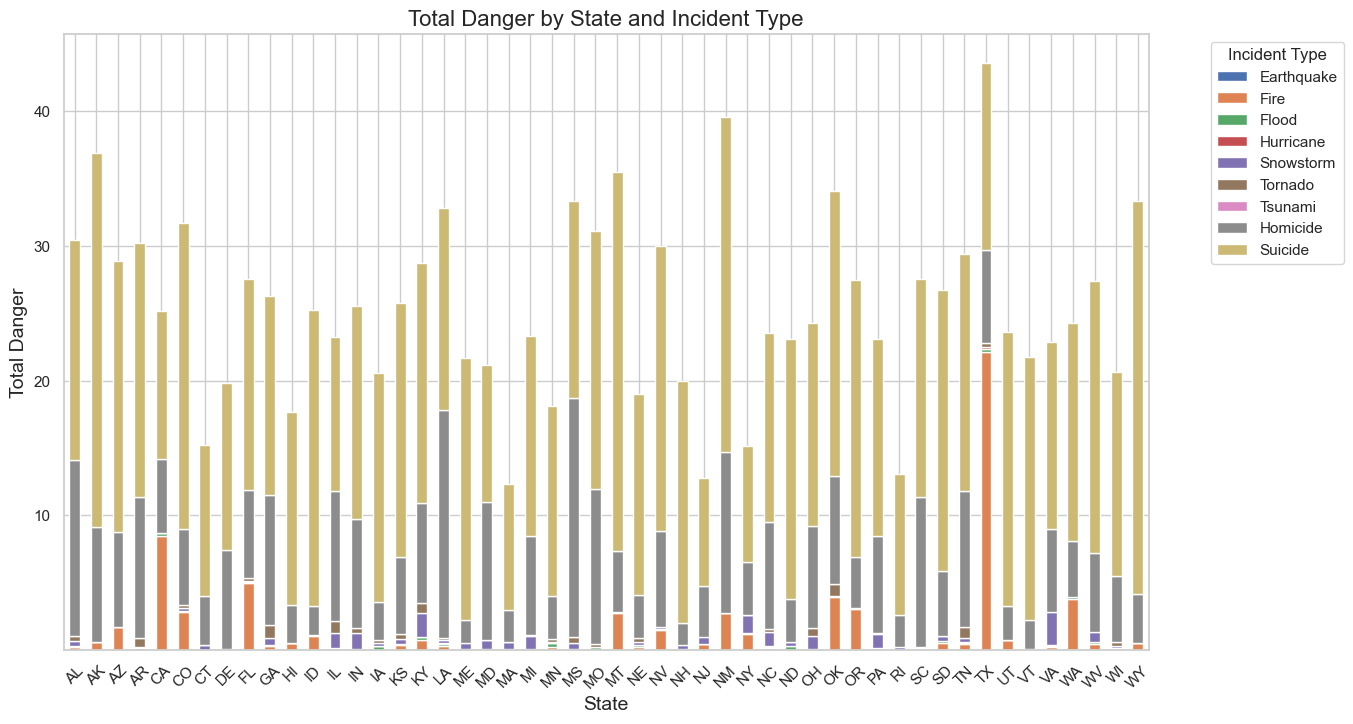

In [161]:
ax = merged_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Total Danger by State and Incident Type', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Total Danger', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

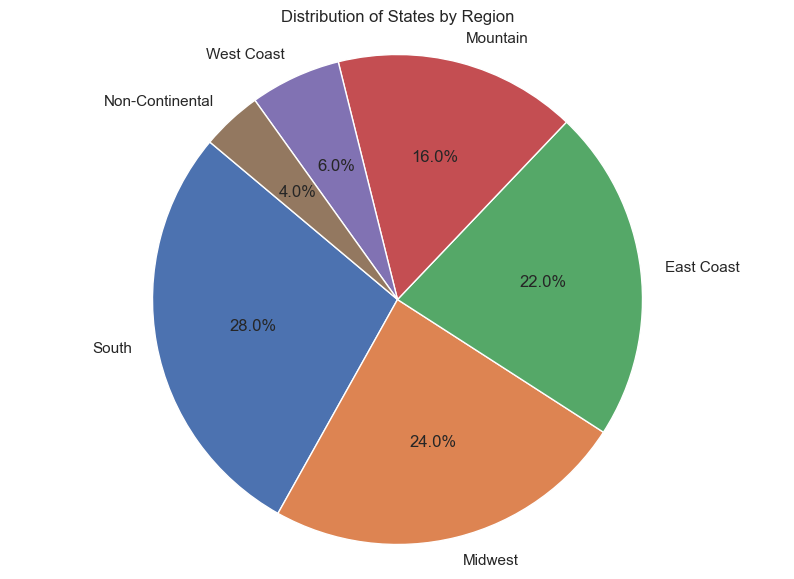

In [162]:
import matplotlib.pyplot as plt
regions = {
    "West Coast": ["CA", "OR", "WA"],
    "Midwest": ["ND", "SD", "NE", "KS", "MO", "IA", "MN", "WI", "IL", "IN", "MI", "OH"],
    "South": ["AL", "AR", "FL", "GA", "KY", "LA", "MS", "NC", "SC", "TN", "TX", "VA", "WV", "OK"],
    "East Coast": ["ME", "NH", "VT", "MA", "RI", "CT", "NJ", "NY", "PA", "DE", "MD"],
    "Mountain": ["ID", "MT", "WY", "CO", "UT", "NM", "AZ", "NV"],
    "Non-Continental": ["AK", "HI"]}

state_categories = {state: region for region, states_list in regions.items() for state in states_list}
merged_df['Region'] = merged_df.index.map(state_categories).fillna("Unknown")

region_counts = merged_df['Region'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of States by Region')
plt.axis('equal') 
plt.show()




In [163]:
merged_df['Total'] = merged_df.sum(axis=1)
plt.figure(figsize=(14, 14))
plt.pie(merged_df['Total'], labels=merged_df.index, autopct='%1.1f%%', startangle=140, pctdistance = .9)
plt.title('Distribution of Total Events by State')
plt.axis('equal') 
plt.show()

TypeError: unsupported operand type(s) for +: 'float' and 'str'

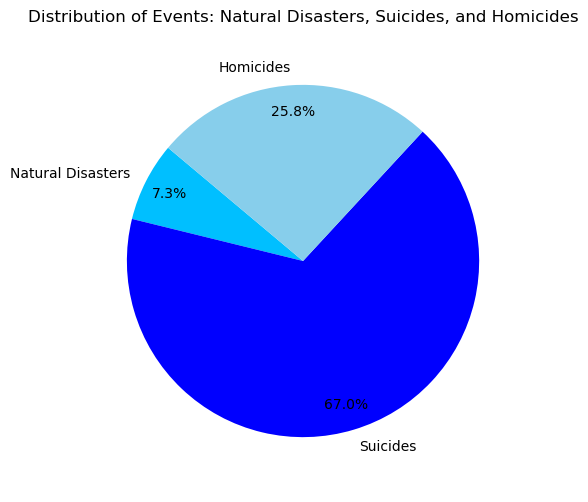

In [43]:
natural_disasters_total = merged_df[['Hurricane', 'Earthquake', 'Fire', 'Flood', 'Snowstorm', 'Tsunami']].sum().sum()
suicides_total = merged_df['Suicide'].sum()
homicides_total = merged_df['Homicide'].sum()

categories = ['Natural Disasters', 'Suicides', 'Homicides']
totals = [natural_disasters_total, suicides_total, homicides_total]

plt.figure(figsize=(5, 6))
plt.pie(totals, labels=categories, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors = ['DeepSkyBlue', 'Blue', 'SkyBlue'])
plt.title('Distribution of Events: Natural Disasters, Suicides, and Homicides')
plt.axis('equal')
plt.show()


In [143]:
import plotly.express as px
import seaborn as sns

data = {
    'State': [
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
    'Value': [ 
        '30.471088', '36.890092', '28.887284', '30.23331', '25.149444', '31.718224',
        '15.226207', '19.793113', '27.5512', '26.309357', '17.687569', '25.264283',
        '23.260963', '25.539543', '20.584389', '25.760018', '28.705356', '32.845813',
        '21.650485', '21.154509', '12.302033', '23.312577', '18.093783', '33.319622',
        '31.114785', '35.520218', '19.001736', '30.007409', '19.982837', '12.781775',
        '39.584989', '15.145145', '23.499882', '23.052027', '24.300656', '34.106639',
        '27.484969', '23.101098', '13.072831', '27.527054', '26.706833', '29.363922',
        '43.556699', '23.586633', '21.732174', '22.865326', '24.239771', '27.36668',
        '20.623951', '33.295612']}

graph_df = pd.DataFrame(data)
graph_df['Value'] = graph_df['Value'].astype(float)

sns.set(style="whitegrid")

fig = px.choropleth(graph_df,
                    locations='State',  
                    locationmode="USA-states",  
                    color='Value',  
                    scope="usa",  
                    color_continuous_scale=px.colors.sequential.Blues,  
                    labels={'Value':'Total Danger'},  
                    color_continuous_midpoint=graph_df['Value'].mean())  

fig.show()

